# Data preparation/exploration for the Aguathon

## Problem definition

Find the best model that predict the level of the Evro river when cros Zaragoza.

----

## Index

1. [Import modules and Data](#first-bullet)
2. [Data exploration](#second-bullet)
3. [Feature Engineering](#third-bullet)
4. [Feature selection](#fourth-bullet)
5. [Missing Values](#fifth-bullet)
   * Split the data in train and test set
6. [Model regressor](#sixth-bullet)
    * Cross-validation

## Import modules and Data <a class="anchor" id="first-bullet"></a>

In [32]:
%load_ext autoreload
%matplotlib inline
#%matplotlib notebook
%autoreload 1


# STD lib imports
import os
import sys

# Third party libs
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from xgboost import plot_importance

# sklear stuff
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error as ecm
from sklearn.metrics import r2_score as r2

import warnings
warnings.filterwarnings('ignore')

# root path of the project
PROJ_ROOT = os.path.join(os.pardir)

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(PROJ_ROOT, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport data.make_dataset
%aimport features.build_features
%aimport visualization.visualize
import data.make_dataset as md
import features.build_features as bf
import visualization.visualize as vs

os.environ['KMP_DUPLICATE_LIB_OK']='True'

print(os.path.abspath(PROJ_ROOT))

# Load data from ITA
raw_file = 'datos.csv'
path = '../ENTRADA/'
df_raw = md.load_data(path, raw_file)

# choose columns
cols = []

# period of the data
start = df_raw.index.min()
end = df_raw.index.max()

idx = df_raw.resample('D').mean().index
print('Shape:', df_raw.shape)
display(df_raw.head())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/miloc/Documents/git-hub/Apsu
Shape: (95856, 10)


,ALAGON_NR,GRISEN_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,pred_24h,pred_48h,pred_72h
time,,,,,,,,,,
2008-01-01 00:00:00,0.8100,0.4375,1.6000,0.2675,0.7875,0.74,False,0.750,0.7400,0.76
2008-01-01 01:00:00,0.8100,0.4725,1.6075,0.2650,0.7900,0.74,False,0.745,0.7325,0.76
2008-01-01 02:00:00,0.8100,0.5425,1.6100,0.2675,0.7900,0.74,False,0.740,0.7300,0.76
2008-01-01 03:00:00,0.8075,0.5500,1.6100,0.2600,0.7900,0.74,False,0.740,0.7200,0.76
2008-01-01 04:00:00,0.8000,0.5525,1.6025,0.2650,0.7900,0.74,False,0.740,0.7200,0.76


In [33]:
# Estation to load data
estaciones = {'pna': '9262-19530901-20190131.csv',  
              'zar_aero':'9434-19410101-20190302.csv'}

# inputs
cols = ['FECHA','TMEDIA','TMIN','TMAX','PRECIPITACION']
path_meteo = '../data/DatosPorEstacion2019-03-02/DatosPorEstacion/'

# Load meteo data and filter by period
df_meteo = md.load_meteo(path_meteo, estaciones, cols) 
    
# complete hourly data
df_meteo = df_meteo.resample('H').ffill()/24

# Filter by period
df_meteo = df_meteo[(df_meteo.index >= start) & (df_meteo.index <= end)]

print('Shape:', df_meteo.shape)
display(df_meteo.tail())

Shape: (95856, 8)


,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero
FECHA,,,,,,,,
2018-12-07 19:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 20:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 21:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 22:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 23:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6


In [34]:
# Concatenate both data frames
df = pd.concat([df_raw, df_meteo], axis=1)

print('Shape:', df.shape)
display(df.tail())

Shape: (95856, 18)


,ALAGON_NR,GRISEN_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,pred_24h,pred_48h,pred_72h,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero
2018-12-07 19:00:00,0.9850,0.6950,1.7300,0.52,0.8450,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 20:00:00,0.9800,0.6925,1.7475,0.52,0.8450,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 21:00:00,0.9675,0.6925,1.7500,0.52,0.8375,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 22:00:00,0.9550,0.6925,1.7400,0.52,0.8300,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 23:00:00,0.9450,0.6925,1.7375,0.52,0.8300,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6


In [35]:
df.isnull().sum()

ALAGON_NR                 16968
GRISEN_NR                  8710
NOVILLAS_NR                1468
TAUSTE_NR                   519
TUDELA_NR                   277
ZGZ_NR                        0
RIESGO                        0
pred_24h                      0
pred_48h                      0
pred_72h                      0
TMEDIA_pna                   48
TMIN_pna                     24
TMAX_pna                     24
PRECIPITACION_pna            24
TMEDIA_zar_aero               0
TMIN_zar_aero                 0
TMAX_zar_aero                 0
PRECIPITACION_zar_aero        0
dtype: int64

## Data exploration <a class="anchor" id="second-bullet"></a>

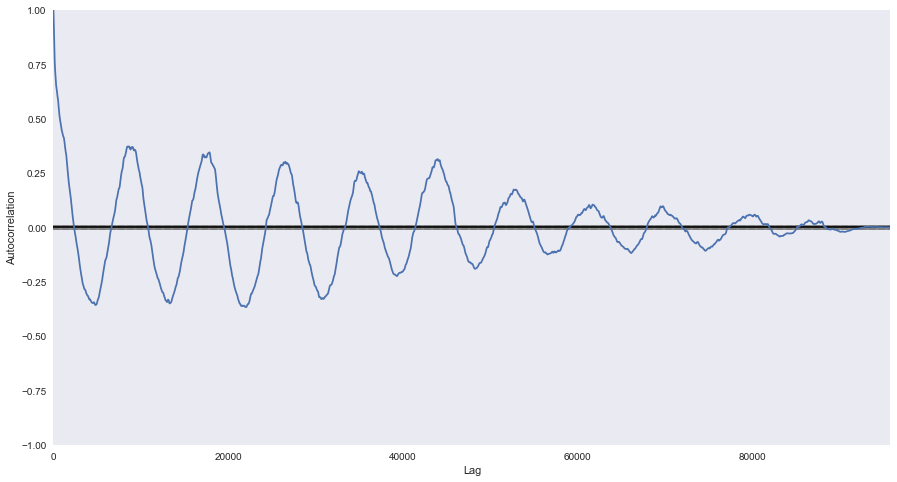

In [36]:
plt.figure(figsize=(15,8))
pd.plotting.autocorrelation_plot(df.NOVILLAS_NR.fillna(0))

(array([2.8175e+04, 6.5440e+03, 5.3100e+03, 3.4870e+03, 1.0292e+04,
        2.0521e+04, 9.9500e+03, 1.8730e+03, 4.0200e+02, 1.1300e+02,
        6.1000e+01, 5.9000e+01, 5.5000e+01, 3.5000e+01, 3.3000e+01,
        2.6000e+01, 3.5000e+01, 1.3000e+01, 1.2000e+01, 1.1000e+01,
        1.2000e+01, 1.1000e+01, 1.2000e+01, 7.0000e+00, 7.0000e+00,
        1.0000e+01, 8.0000e+00, 5.0000e+00, 6.0000e+00, 5.0000e+00,
        8.0000e+00, 1.7000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        3.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00, 1.1000e+01]),
 array([0.07    , 0.170125, 0.27025 , 0.370375, 0.4705  , 0.570625,
        0.67075 , 0.770875, 0.871   , 0.971125, 1.07125 , 1.171375,
        1.2715  , 1.371625, 1.47175 , 1.571875, 1.672   , 1.772125,
        1.87225 , 1.972375, 2.0725  , 2.172625, 2.27275 , 2.372875,
        2.473   , 2.573125, 2.67325 , 2.773375, 2.8735  , 2.973625,
        3.07375 , 3.173875, 3.274   , 3.374125, 3.47425 , 3.574375,
        3.6745  , 3.774625, 3.87475 , 3.974875

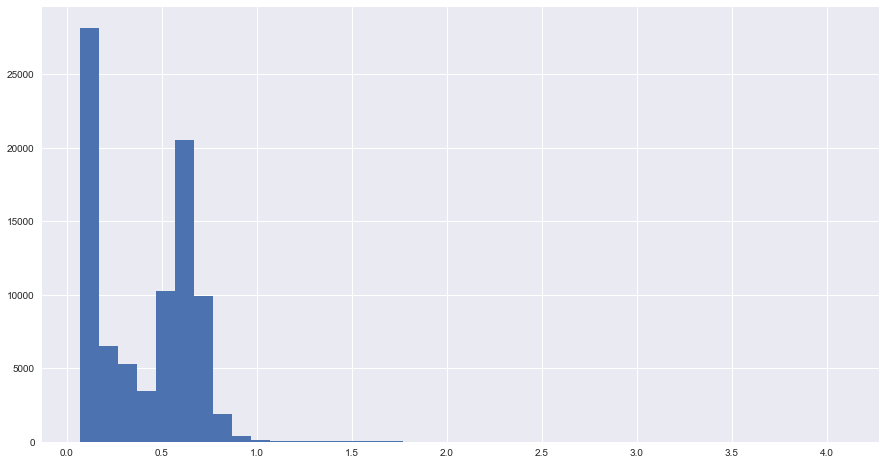

In [37]:
# histogram
plt.figure(figsize=(15,8))
plt.hist(df.GRISEN_NR.values, 40)

In [38]:
df = df.drop(['GRISEN_NR'], axis=1)

[<matplotlib.lines.Line2D at 0x13dc65198>]

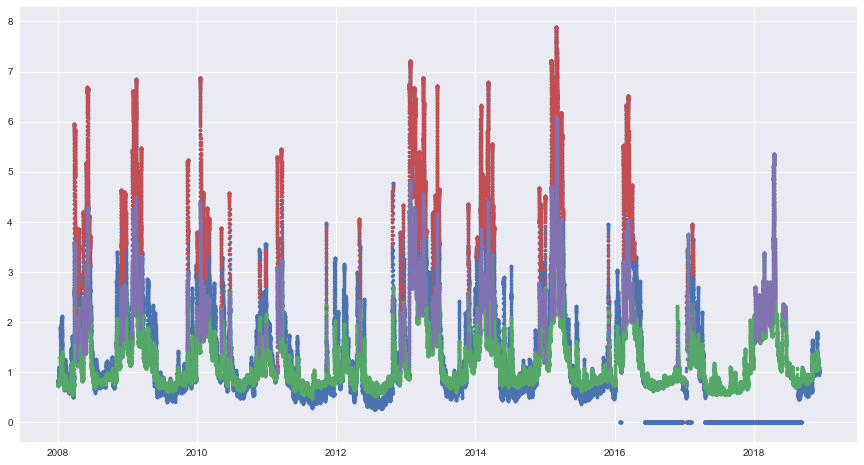

In [39]:
plt.figure(figsize=(15,8))
plt.plot(df.ALAGON_NR.fillna(0), '.')
plt.plot(df.ZGZ_NR.fillna(0), '.')
plt.plot(df[df.RIESGO==1].ALAGON_NR, '.')
plt.plot(df[df.RIESGO==1].ZGZ_NR, '.')

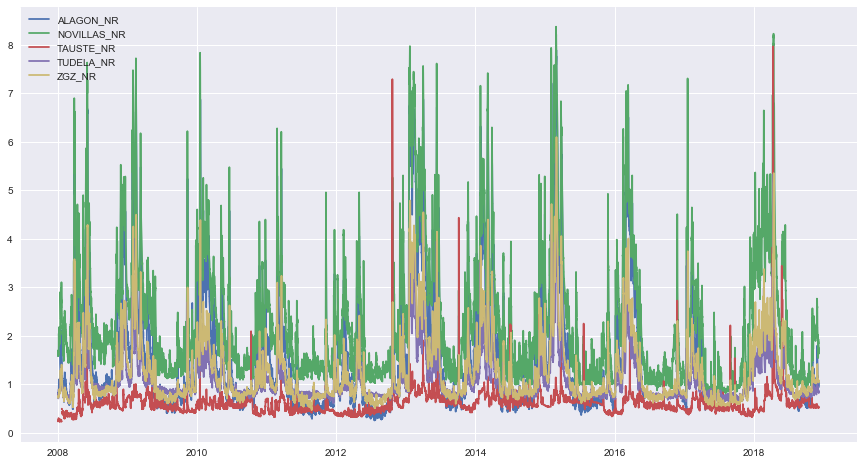

In [40]:
df.iloc[:,:5].plot(figsize=(15,8))

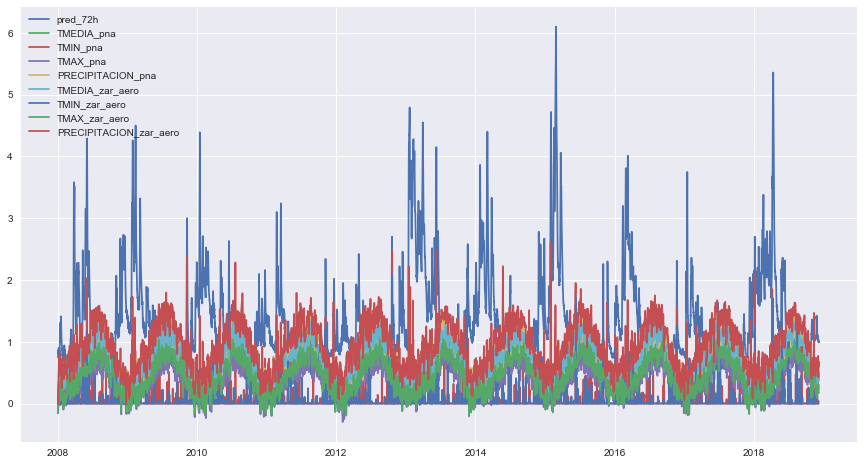

In [41]:
df.iloc[:,8:].plot(figsize=(15,8))

(array([3.7850e+03, 3.8529e+04, 1.7367e+04, 9.0290e+03, 5.7900e+03,
        4.1030e+03, 3.4730e+03, 2.8820e+03, 2.1650e+03, 1.5470e+03,
        1.2690e+03, 1.1130e+03, 8.7300e+02, 5.5700e+02, 3.4900e+02,
        3.5700e+02, 3.5200e+02, 2.1900e+02, 2.7500e+02, 2.4800e+02,
        3.0000e+02, 1.9800e+02, 1.9200e+02, 1.2300e+02, 1.0600e+02,
        8.1000e+01, 4.0000e+01, 3.2000e+01, 5.0000e+01, 4.3000e+01,
        2.9000e+01, 1.0000e+01, 1.2000e+01, 1.0000e+01, 1.6000e+01,
        9.0000e+00, 6.0000e+00, 1.1000e+01, 1.7000e+01, 1.2000e+01]),
 array([0.6075, 0.7385, 0.8695, 1.0005, 1.1315, 1.2625, 1.3935, 1.5245,
        1.6555, 1.7865, 1.9175, 2.0485, 2.1795, 2.3105, 2.4415, 2.5725,
        2.7035, 2.8345, 2.9655, 3.0965, 3.2275, 3.3585, 3.4895, 3.6205,
        3.7515, 3.8825, 4.0135, 4.1445, 4.2755, 4.4065, 4.5375, 4.6685,
        4.7995, 4.9305, 5.0615, 5.1925, 5.3235, 5.4545, 5.5855, 5.7165,
        5.8475]),
 <a list of 40 Patch objects>)

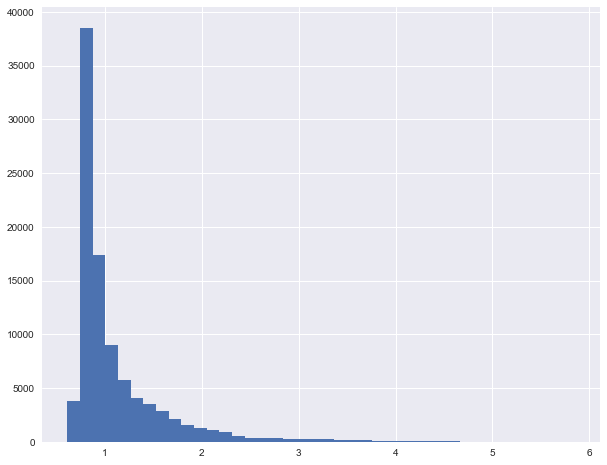

In [42]:
plt.figure(figsize=(10,8))
plt.hist(df.TUDELA_NR.values, 40)

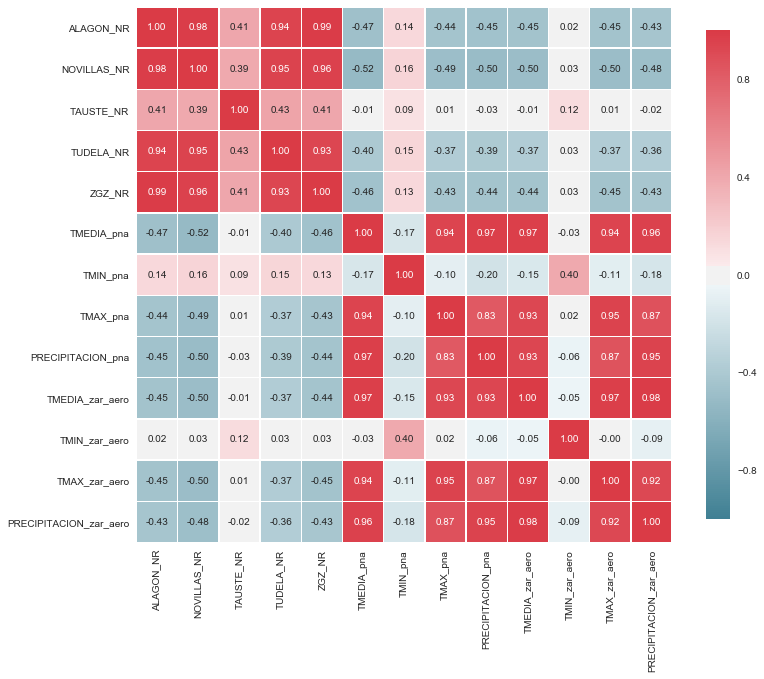

In [43]:
vs.corr_heatmap(pd.concat([df.iloc[:,:5], df.iloc[:,9:]], axis=1))

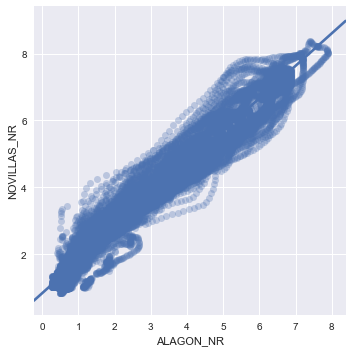

In [44]:
sns.lmplot(x='ALAGON_NR', y='NOVILLAS_NR', data=df, palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

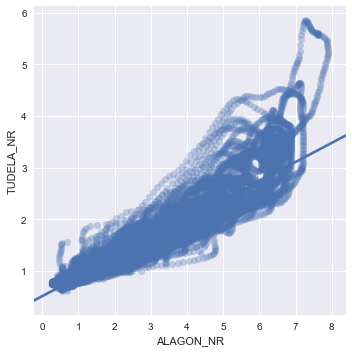

In [45]:
sns.lmplot(x='ALAGON_NR', y='TUDELA_NR', data=df, palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

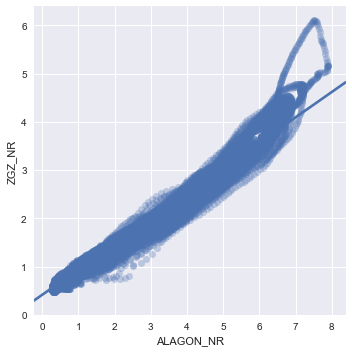

In [46]:
sns.lmplot(x='ALAGON_NR', y='ZGZ_NR', data=df, palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

In [47]:
df.columns

Index(['ALAGON_NR', 'NOVILLAS_NR', 'TAUSTE_NR', 'TUDELA_NR', 'ZGZ_NR',
       'RIESGO', 'pred_24h', 'pred_48h', 'pred_72h', 'TMEDIA_pna', 'TMIN_pna',
       'TMAX_pna', 'PRECIPITACION_pna', 'TMEDIA_zar_aero', 'TMIN_zar_aero',
       'TMAX_zar_aero', 'PRECIPITACION_zar_aero'],
      dtype='object')

## Feature engineering <a class="anchor" id="third-bullet"></a>

In [48]:
# Features
columns_y = ['pred_24h', 'pred_48h', 'pred_72h']
columns_x = [x for x in df.columns if x not in columns_y]

X = df[columns_x]
Y = df[columns_y[2]]

# Create features base on delta to time
cols_delt = columns_x[:5]
X = bf.delta_height(X, cols_delt, 1, True)
X = bf.delta_height(X, cols_delt, 5, True)

print('Shape:', X.shape)
display(X.head())

Shape: (95850, 24)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,...,delta_1_ALAGON_NR,delta_1_NOVILLAS_NR,delta_1_TAUSTE_NR,delta_1_TUDELA_NR,delta_1_ZGZ_NR,delta_5_ALAGON_NR,delta_5_NOVILLAS_NR,delta_5_TAUSTE_NR,delta_5_TUDELA_NR,delta_5_ZGZ_NR
2008-01-01 06:00:00,0.800,1.590,0.2600,0.7825,0.7425,False,0.083333,0.0,-0.158333,0.329167,...,0.000,0.005,-0.0025,0.0075,-0.0025,0.0020,0.0035,0.0010,0.0015,-0.0005
2008-01-01 07:00:00,0.795,1.590,0.2525,0.7800,0.7500,False,0.083333,0.0,-0.158333,0.329167,...,0.005,0.000,0.0075,0.0025,-0.0075,0.0030,0.0040,0.0030,0.0020,-0.0020
2008-01-01 08:00:00,0.790,1.595,0.2550,0.7750,0.7500,False,0.083333,0.0,-0.158333,0.329167,...,0.005,-0.005,-0.0025,0.0050,0.0000,0.0035,0.0030,0.0010,0.0030,-0.0020
2008-01-01 09:00:00,0.790,1.600,0.2525,0.7800,0.7500,False,0.083333,0.0,-0.158333,0.329167,...,0.000,-0.005,0.0025,-0.0050,0.0000,0.0020,0.0005,0.0025,0.0020,-0.0020
2008-01-01 10:00:00,0.790,1.610,0.2550,0.7800,0.7500,False,0.083333,0.0,-0.158333,0.329167,...,0.000,-0.010,-0.0025,0.0000,0.0000,0.0020,-0.0030,0.0005,0.0020,-0.0020


## Missing Values <a class="anchor" id="fifth-bullet"></a>

In [49]:
# List the columns that contain missing values
X.isnull().sum()

ALAGON_NR                 16968
NOVILLAS_NR                1468
TAUSTE_NR                   519
TUDELA_NR                   277
ZGZ_NR                        0
RIESGO                        0
TMEDIA_pna                   48
TMIN_pna                     24
TMAX_pna                     24
PRECIPITACION_pna            24
TMEDIA_zar_aero               0
TMIN_zar_aero                 0
TMAX_zar_aero                 0
PRECIPITACION_zar_aero        0
delta_1_ALAGON_NR         16975
delta_1_NOVILLAS_NR        1501
delta_1_TAUSTE_NR           541
delta_1_TUDELA_NR           279
delta_1_ZGZ_NR                0
delta_5_ALAGON_NR         17003
delta_5_NOVILLAS_NR        1626
delta_5_TAUSTE_NR           613
delta_5_TUDELA_NR           287
delta_5_ZGZ_NR                0
dtype: int64

In [50]:
# Most simple thing, remove missing values
X = X.dropna()
Y = Y[X.index]
X.isnull().sum()

ALAGON_NR                 0
NOVILLAS_NR               0
TAUSTE_NR                 0
TUDELA_NR                 0
ZGZ_NR                    0
RIESGO                    0
TMEDIA_pna                0
TMIN_pna                  0
TMAX_pna                  0
PRECIPITACION_pna         0
TMEDIA_zar_aero           0
TMIN_zar_aero             0
TMAX_zar_aero             0
PRECIPITACION_zar_aero    0
delta_1_ALAGON_NR         0
delta_1_NOVILLAS_NR       0
delta_1_TAUSTE_NR         0
delta_1_TUDELA_NR         0
delta_1_ZGZ_NR            0
delta_5_ALAGON_NR         0
delta_5_NOVILLAS_NR       0
delta_5_TAUSTE_NR         0
delta_5_TUDELA_NR         0
delta_5_ZGZ_NR            0
dtype: int64

In [51]:
# MinMax scale
scaler = MinMaxScaler()
columnas = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=columnas)

### Split the data in train and test set

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(x_train.shape)
display(x_train.head())

(53788, 24)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,...,delta_1_ALAGON_NR,delta_1_NOVILLAS_NR,delta_1_TAUSTE_NR,delta_1_TUDELA_NR,delta_1_ZGZ_NR,delta_5_ALAGON_NR,delta_5_NOVILLAS_NR,delta_5_TAUSTE_NR,delta_5_TUDELA_NR,delta_5_ZGZ_NR
10919,0.212111,0.252405,0.082037,0.098854,0.151865,0.0,0.336111,0.019108,0.390625,0.276347,...,0.686099,0.811538,0.684211,0.393204,0.707317,0.605650,0.741001,0.658069,0.537037,0.654185
1992,0.235025,0.298839,0.057638,0.127507,0.170515,0.0,0.422222,0.049363,0.440625,0.384075,...,0.699552,0.771154,0.665635,0.344660,0.739837,0.658757,0.712906,0.649963,0.449074,0.693833
12350,0.047463,0.098507,0.043140,0.061605,0.047957,0.0,0.666667,0.081210,0.575000,0.697892,...,0.699552,0.815385,0.678019,0.393204,0.723577,0.654237,0.752414,0.651437,0.525463,0.660793
37451,0.102455,0.147264,0.023338,0.058739,0.103908,0.0,0.594444,0.000000,0.525000,0.613583,...,0.721973,0.807692,0.678019,0.378641,0.764228,0.677966,0.763828,0.656595,0.546296,0.707048
48550,0.048118,0.038143,0.070014,0.033906,0.053286,0.0,0.686111,0.000000,0.693750,0.639344,...,0.721973,0.821154,0.678019,0.383495,0.715447,0.674576,0.755048,0.648489,0.518519,0.669604


## Model regressor <a class="anchor" id="sixth-bullet"></a>

In [ ]:
## Linear Regressor
regr = LinearRegression()

regr.fit(x_train, y_train)
print('r2_score = %0.2f' % regr.score(x_test, y_test))
print('ECM_score = %0.3f' % ecm(regr.predict(x_test), y_test))

In [ ]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

xgb.fit(x_train, y_train)
print('r2_score = %0.2f' % xgb.score(x_test, y_test))
print('ECM_score = %0.3f' % ecm(xgb.predict(x_test), y_test))

### Cross-validation

In [ ]:
kfold = KFold(n_splits=10, random_state=7)
scoring = 'r2'
scores = cross_val_score(regr, X, Y, cv=kfold, scoring=scoring)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean()*100.0, scores.std()*100.0))

Accuracy: 83.74 (+/- 7.99)


In [ ]:
scores = cross_val_score(xgb, X, Y, cv=kfold, scoring=scoring)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean()*100.0, scores.std()*100.0))
print('Confidence interval 66%')
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean()*100.0, scores.std()*100.0 * 2))
print('Confidence interval 95%')
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean()*100.0, scores.std()*100.0 * 2.6))
print('Confidence interval 99%')

## Feature selection <a class="anchor" id="fourth-bullet"></a>

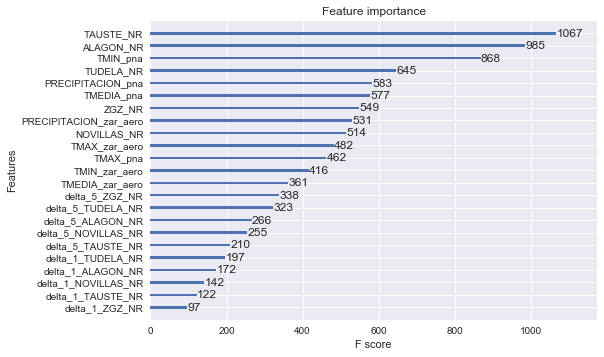

In [30]:
# plot feature importance
plot_importance(xgb)
plt.show()

In [31]:
from sklearn.feature_selection import SelectFromModel

# Fit model using each importance as a threshold
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
    select_x = selection.transform(X)
    
    # train model
    selection_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                                           colsample_bytree=1, max_depth=7)
    
    scores = cross_val_score(selection_model, select_x, Y, cv=kfold, scoring=scoring)
    
    # eval model
    print("Thresh=%.3f, n=%d, Accuracy: %0.2f (+/- %0.2f)" % (thresh, select_x.shape[1], 
                                                              scores.mean()*100.0, 
                                                              scores.std()*100.0 * 2))

Thresh=0.000, n=24, Accuracy: 85.71 (+/- 10.38)
Thresh=0.000, n=23, Accuracy: 85.71 (+/- 10.38)
Thresh=0.001, n=23, Accuracy: 85.71 (+/- 10.38)
Thresh=0.002, n=23, Accuracy: 85.71 (+/- 10.38)
Thresh=0.002, n=23, Accuracy: 85.71 (+/- 10.38)
Thresh=0.005, n=23, Accuracy: 85.71 (+/- 10.38)
Thresh=0.006, n=23, Accuracy: 85.71 (+/- 10.38)
Thresh=0.006, n=23, Accuracy: 85.71 (+/- 10.38)
Thresh=0.006, n=23, Accuracy: 85.71 (+/- 10.38)
Thresh=0.008, n=23, Accuracy: 85.71 (+/- 10.38)
Thresh=0.008, n=23, Accuracy: 85.71 (+/- 10.38)
Thresh=0.009, n=23, Accuracy: 85.71 (+/- 10.38)
Thresh=0.011, n=22, Accuracy: 85.78 (+/- 10.37)
Thresh=0.014, n=21, Accuracy: 85.77 (+/- 10.42)
Thresh=0.014, n=20, Accuracy: 85.79 (+/- 10.43)
Thresh=0.015, n=20, Accuracy: 85.79 (+/- 10.43)
Thresh=0.016, n=20, Accuracy: 85.79 (+/- 10.43)
Thresh=0.026, n=16, Accuracy: 85.50 (+/- 10.03)
Thresh=0.031, n=15, Accuracy: 85.37 (+/- 10.38)
Thresh=0.034, n=13, Accuracy: 84.33 (+/- 11.59)
Thresh=0.051, n=8, Accuracy: 82.55 (+/- 